In [22]:
import pandas as pd
import cptac
import cptac.pancan as pc
import scipy.stats
import seaborn as sns

import plot_utils as p
import cptac.utils as ut

In [23]:
def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [24]:
def get_corr(df, dup_list):
    
    
    new = pd.DataFrame()
    
    for i in dup_list:
        ids = df.columns[df.columns.str.contains(i)].to_list()
        ids.remove(i+'_flagship')
        flag = i+'_flagship'
        
        for  ali in ids:
            test_df = both[[flag, ali]].dropna() # only plots if value for both flagship and panan
            # Create df with correlations
            first = p.wrap_pearson_corr(test_df, flag)
            new = new.append(first)
    return new

In [25]:
# correlation analysis: compares flagship values to duplicates in pancan
# df is df with both flagship and pancan values (flagship marked as '_flagship')
# dup_list is list of Patient IDs (without aliquots attached)
# y_lab is which source 

def wrap_lin_reg(df, dup_list, y_lab, wa = True):
    for i in dup_list:
        if wa == True:
            if '.N' in i:
                ids = df.columns[df.columns.str.contains(i)].to_list()
            else:
                ids = df.columns[df.columns.str.contains(i) & ~ df.columns.str.contains('\.N')].to_list()
            ids.remove(i+'_flagship')
            flag = i+'_flagship'
        else:
            flag = i+'_flagship'
            ids = [i, i+'_1']           

        for first in ids:
            plot_df = both[[flag, first]].dropna(axis = 'index', how = 'any')
            xd = plot_df[flag].min() + ((plot_df[flag].max() - plot_df[flag].min()) / 3) 
            yd = plot_df[first].max() +1


            p.plot_pearson(plot_df, flag, first, x_coor = xd, y_coor = yd, y_label = first+'_pdc',
                   hue = "none", title = "", ra_stats = True,
                   show_plot = True)

In [26]:
def get_flag_df(omics_name, ca, dup_list):
    if omics_name == 'prot':
        df = ca.get_proteomics()
    
    elif omics_name == 'phospho':
        df = ca.get_phosphoproteomics()
        
    elif omics_name == 'acetyl':
        df = ca.get_acetylproteomics()
        
    if ca.get_cancer_type() == 'brca':
        df.index = [x[1:] if x[0] == 'X' else x for x in df.index]

    df = df.loc[df.index.isin(dup_list)]
    df.index = df.index+'_flagship'
    if isinstance(df.keys(), pd.core.indexes.multi.MultiIndex):
        if omics_name == 'prot':
            df = ut.reduce_multiindex(df, levels_to_drop = ['Database_ID'])
        else: # phospho and acetyl
            df = ut.reduce_multiindex(df, levels_to_drop = ['Peptide', 'Database_ID'], flatten = True)
        df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
    fdf = df.T
    
    if ca.get_cancer_type() == 'luad' and omics_name == 'phospho':
        # capitalize AA sites 
        fdf.index = fdf.index.str.upper()
    
    return fdf     

In [135]:
def get_pc_df(omics_name, ca_obj, source_name, dup_list = [], with_aliquots = True):
    if omics_name == 'prot':
        df = ca_obj.get_proteomics(source_name)
    
    elif omics_name == 'phospho':
        df = ca_obj.get_phosphoproteomics(source_name)
        
    elif omics_name == 'acetyl':
        df = ca_obj.get_acetylproteomics(source_name)
        
    
    if with_aliquots == False:
        df = df.loc[df.index.duplicated(keep = False)]
        if omics_name != 'prot':
            df = ut.reduce_multiindex(df, levels_to_drop=[1], flatten = True)
            df = df.loc[:,~df.columns.duplicated()]
        df = df.T
        df = df.drop(['aliquot_submitter_id', 'case_submitter_id'])
    
    # When using aliquots, pass in a list of patient_IDs
    else:
        df = df.reset_index()
        if omics_name != 'prot':
            df = ut.reduce_multiindex(df, levels_to_drop=[1], flatten = True)
            df = df.loc[:,~df.columns.duplicated()]
        # brca wasn't mapped (no .N) so use case_submitter_id
        if ca_obj.get_cancer_type() == 'pancanbrca': 
            df = df.loc[df.case_submitter_id.isin(dup_list)] # test with 21BR010 -> only 1 aliquot but part of 18 IDs with normal
            to_drop = ['case_submitter_id', 'aliquot_submitter_id']
            
        # luad and hnscc were mapped so use Patient_ID
        else: 
            df = df.loc[df.Patient_ID.isin(dup_list)]
            to_drop = ['case_submitter_id', 'aliquot_submitter_id', 'Patient_ID']
        df.index = df.case_submitter_id+'_'+df.aliquot_submitter_id
        df = df.T
        df = df.drop(to_drop)
    
    df.index = df.index.str.upper()   
    df = rename_duplicate_cols(df)
        
    return df

# Brca

In [28]:
b = pc.PancanBrca()
brca = cptac.Brca(version='3.1.1')

cptac warning: Old brca data version. Latest is 5.4. This is 3.1.1. (<ipython-input-28-04548f4bd6d7>, line 2)


In [ ]:
# show which omics has duplicates
ca = b
source_name = 'pdc'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
acetyl = ca.get_acetylproteomics(source_name)
print('prot:', set(prot.index.duplicated()), len(prot.index[prot.index.duplicated()]), 'duplicates')
print('phospho:', set(phos.index.duplicated()), len(phos.index[phos.index.duplicated()]), 'duplicates')
print('acetyl:', set(acetyl.index.duplicated()), len(acetyl.index[acetyl.index.duplicated()]), 'duplicates')

In [56]:
# From prosp-brca-all-samples.txt
rep = ['11BR031', '11BR053', '11BR036', '11BR060', '14BR005', '11BR011', '21BR010'] # 2 replicates for 11BR036

norm = ['11BR074', '11BR073', '20BR007', '21BR010', '11BR017', '05BR029', '18BR003', '11BR030',
        '01BR027','11BR025', '11BR047', '11BR028', '11BR020', '20BR008', '11BR024', '11BR023',
        '11BR015', '11BR006']

print('IDs with replicates (all tumor):', len(rep))
print('IDs with a normal sample taken:', len(norm))

IDs with replicates (all tumor): 7
IDs with a normal sample taken: 18


Comment out everything except line with map_database_to_gene_pdc function in PdcBrca.py formatting section in order to use below code.

In [57]:
#example:
'''
phos = self._data["phosphoproteomics"]
#phos = phos.drop(drop_aliquots, level = 'aliquot_submitter_id') # drop normal aliquots (QC issues)
#phos = phos.rename(index={'604':'CPT000814'}) # use the aliquot for 604
#phos.index = phos.index.droplevel('aliquot_submitter_id')
#phos = rename_duplicate_labels(phos, 'index') # give replicates unique names (checked that only replicates remain)
#phos = average_replicates(phos, id_list = replicates) # average replicates
phos = map_database_to_gene_pdc(phos, 'refseq') # Map refseq IDs to gene names
self._data["phosphoproteomics"] = phos'''

'\nphos = self._data["phosphoproteomics"]\n#phos = phos.drop(drop_aliquots, level = \'aliquot_submitter_id\') # drop normal aliquots (QC issues)\n#phos = phos.rename(index={\'604\':\'CPT000814\'}) # use the aliquot for 604\n#phos.index = phos.index.droplevel(\'aliquot_submitter_id\')\n#phos = rename_duplicate_labels(phos, \'index\') # give replicates unique names (checked that only replicates remain)\n#phos = average_replicates(phos, id_list = replicates) # average replicates\nphos = map_database_to_gene_pdc(phos, \'refseq\') # Map refseq IDs to gene names\nself._data["phosphoproteomics"] = phos'

In [58]:
#omics = 'prot'
#omics = 'phospho'
omics = 'acetyl' # needs work
nr_list = norm # choose norm or rep
pcdf = get_pc_df(omics, b, 'pdc', dup_list = nr_list, with_aliquots = True)
pcdf

cptac warning: Due to dropping the specified levels, dataframe now has 330 duplicated column headers. (<ipython-input-27-8e8438c23499>, line 23)


,01BR027_1990853a-0e82-40b3-a025-91cdc1_D2,01BR027_64ee175f-f3ce-446e-bbf4-9b6fa8_D1,05BR029_7ac27de9-0932-4ff5-aab8-29c527,05BR029_d0ce3c06-9c4c-41bd-b583-9254b0_D2,11BR006_3208e021-1dae-42fd-bd36-0f3c3d,11BR006_4798bb9d-7100-43aa-b615-85897d_D2,11BR015_6c660b6b-bfda-47b0-9499-160d49,11BR015_cab796c6-0129-43cf-bd27-7da395_D2,11BR017_241c8dec-b317-4794-8cc2-07c14c_D2,11BR017_241ecd0e-89bd-4d3a-81b3-55a250,...,11BR074_3367406e-d39c-4641-a3e7-44e1f3,18BR003_436297af-feb7-4754-96b7-c5bfb5_D2,18BR003_e3d45dc6-66ef-4e0b-9d96-1b5db5,20BR007_33adae13-5dbd-4530-a5d5-3763e4,20BR007_547f521a-5851-426c-a125-d9d82c_D2,20BR008_acf022b3-7f01-43b3-ac14-86f97d,20BR008_b87e7f88-a1f2-425a-8cff-8ae4b9_D2,21BR010_39f81c85-1832-45eb-829a-3040ad,21BR010_68ef4aa9-00b0-4528-8828-4d3e43_D2,21BR010_68ef4aa9-00b0-4528-8828-4d3e43_D2_1
Name,,,,,,,,,,,,,,,,,,,,,
A1BG_K248,NaN,NaN,10.285,0.0093,0.344,-0.8753,3.253,0.3316,NaN,12.675,...,14.0189,NaN,12.0731,NaN,1.3564,0.616,2.7557,NaN,NaN,NaN
A1BG_K441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1BG_K78,0.4211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0408,NaN
A2M_K1019,NaN,NaN,NaN,NaN,0.7723,NaN,1.352,NaN,NaN,NaN,...,NaN,-0.0786,NaN,NaN,NaN,0.8156,NaN,NaN,NaN,NaN
A2M_K1092,NaN,0.9139,-0.5668,-0.9105,NaN,-0.393,NaN,-0.8401,NaN,1.0817,...,1.4976,-0.1453,0.9631,-1.1653,NaN,NaN,NaN,-0.8607,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZEF1_K2306,NaN,NaN,NaN,-0.4614,NaN,NaN,NaN,-0.1741,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.924,NaN,-0.9728,NaN,NaN,NaN
ZZZ3_K117,NaN,NaN,NaN,-0.1779,NaN,-0.658,NaN,0.2235,NaN,NaN,...,NaN,NaN,NaN,NaN,0.627,NaN,-1.6293,NaN,NaN,NaN
ZZZ3_K161,NaN,NaN,NaN,0.8696,NaN,-1.8834,NaN,0.4764,NaN,NaN,...,NaN,1.3175,NaN,NaN,-0.2512,NaN,0.4361,NaN,NaN,-2.0802


In [ ]:
fdf = get_flag_df(omics, brca, nr_list)
fdf

In [ ]:
both = fdf.join(pcdf, how = 'inner')
both = both.dropna(axis = 1, how = 'all')
both

In [ ]:
# TypeError: arg must be a list, tuple, 1-d array, or Series
# can occur if column contains on NaN (like with PDC phospho for brca)
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

In [ ]:
wrap_lin_reg(both, nr_list, y_lab = source_name)

In [ ]:
print(omics)
get_corr(both, nr_list)

In [98]:
# Check the aliquots we dropped were normal samples using the biospecimen manifest for Brca proteomics on the PDC website.
pdc_prot = pd.read_csv('../../../../Downloads/PDC_biospecimen_manifest_07232021_103448_prot.tsv', sep='\t')
df = pdc_prot[['Case Submitter ID', 'Aliquot Submitter ID', 'Sample Type', 'Project Name']]
df = df.loc[df['Project Name'] == 'CPTAC2 Confirmatory']
prot_norm = df.loc[df['Sample Type'] == 'Solid Tissue Normal']
pdc_prot = prot_norm['Aliquot Submitter ID'].to_list()
pdc_prot.sort()

prot_dropped_aliquots = ['64ee175f-f3ce-446e-bbf4-9b6fa8_D1', '7ac27de9-0932-4ff5-aab8-29c527',
            '3208e021-1dae-42fd-bd36-0f3c3d', '6c660b6b-bfda-47b0-9499-160d49','241ecd0e-89bd-4d3a-81b3-55a250',
            '428de0d4-7f84-4075-bae1-352af6', '0a80d3c4-0758-447a-958c-ea868c', '53723086-8858-4395-93d7-0baa68',
            '1740224c-32d1-4c9f-98c6-653363', '885fe794-a98e-4f81-a284-ac4bb8', '4749ba99-d3b8-4ae3-b6f6-458bc7',
            '81116212-b7e6-454b-9579-105cf3', '1664b920-5e60-4e3b-9aab-fe121c', '3367406e-d39c-4641-a3e7-44e1f3',
            'e3d45dc6-66ef-4e0b-9d96-1b5db5', '33adae13-5dbd-4530-a5d5-3763e4', 'acf022b3-7f01-43b3-ac14-86f97d',
            '39f81c85-1832-45eb-829a-3040ad']

prot_dropped_aliquots.sort()
print('True = lists equal each other (have all aliquots)')
prot_dropped_aliquots == pdc_prot

True = lists equal each other (have all aliquots)


True

In [110]:
# Check the aliquots we dropped were normal samples using the biospecimen manifest for Brca acetylproteomics on the PDC website.
pdc_acetyl = pd.read_csv('../../../../Downloads/PDC_biospecimen_manifest_07232021_103319_acetyl.tsv', sep='\t')
df = pdc_acetyl[['Case Submitter ID', 'Aliquot Submitter ID', 'Sample Type', 'Project Name']]
df = df.loc[df['Project Name'] == 'CPTAC2 Confirmatory']
pdc_acetyl = df.loc[df['Sample Type'] == 'Solid Tissue Normal']
pdc_acetyl = pdc_acetyl['Aliquot Submitter ID'].to_list()
pdc_acetyl.sort()

ac_dropped_aliquots = ['3208e021-1dae-42fd-bd36-0f3c3d', '39f81c85-1832-45eb-829a-3040ad', '4749ba99-d3b8-4ae3-b6f6-458bc7',
              '81116212-b7e6-454b-9579-105cf3', '0a80d3c4-0758-447a-958c-ea868c', '3367406e-d39c-4641-a3e7-44e1f3',
              '241ecd0e-89bd-4d3a-81b3-55a250', '428de0d4-7f84-4075-bae1-352af6', '7ac27de9-0932-4ff5-aab8-29c527',
              'acf022b3-7f01-43b3-ac14-86f97d', '1664b920-5e60-4e3b-9aab-fe121c', '6c660b6b-bfda-47b0-9499-160d49',
              'e3d45dc6-66ef-4e0b-9d96-1b5db5', '64ee175f-f3ce-446e-bbf4-9b6fa8_D1', '33adae13-5dbd-4530-a5d5-3763e4',
              '53723086-8858-4395-93d7-0baa68', '1740224c-32d1-4c9f-98c6-653363', '885fe794-a98e-4f81-a284-ac4bb8']
ac_dropped_aliquots.sort()
print('True = lists equal each other (have all aliquots)')
ac_dropped_aliquots == pdc_acetyl

True = lists equal each other (have all aliquots)


True

In [111]:
# Are the normal aliquots the same between omics? Yes
prot_dropped_aliquots == ac_dropped_aliquots

True

# Hnscc

Check correlation of replicates with each other (confirmed same tissue type).

In [7]:
h = pc.PancanHnscc()
hnscc = cptac.Hnscc()

In [119]:
# show which omics has duplicates
ca = h
source_name = 'umich'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
#acetyl = ca.get_acetylproteomics(source_name) # not included in pdchnscc
print('prot:', set(prot.index.duplicated()), list(prot.index[prot.index.duplicated()]))
print('phospho:', set(phos.index.duplicated()), list(set(phos.index[phos.index.duplicated()])))
#print('acetyl:', set(acetyl.index.duplicated()))

prot: {False} []
phospho: {False} []


In [120]:
# umich
df = prot.reset_index()
df = df.replace('-T-duplicate', '', regex = True)
df = df.replace('-N-duplicate\d?', '.N', regex = True)
df.loc[df.Patient_ID.str.contains('duplicate')]

Name,Patient_ID,ARF5,M6PR,ESRRA,FKBP4,NDUFAF7,FUCA2,HS3ST1,SEMA3F,CFTR,...,BTD,TNK2,ETNK1,MYO6,MPZ,EED,DDHD1,ZBTB3,WIZ,RFX7
Database_ID,,ENSP00000000233.5,ENSP00000000412.3,ENSP00000000442.6,ENSP00000001008.4,ENSP00000002125.4,ENSP00000002165.5,ENSP00000002596.5,ENSP00000002829.3,ENSP00000003084.6,...,ENSP00000500403.1,ENSP00000500452.1,ENSP00000500633.1,ENSP00000500710.1,ENSP00000500814.2,ENSP00000500914.1,ENSP00000500986.2,ENSP00000501025.1,ENSP00000501300.1,ENSP00000501317.1


In [121]:
# Keep aliquots
df = h.get_phosphoproteomics('pdc')
df = df.reset_index()
df = df.loc[df.Patient_ID.duplicated(keep = False)]
df = ut.reduce_multiindex(df, levels_to_drop = [1], flatten=True)
df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
df.index = df.Patient_ID+'_'+df.aliquot_submitter_id # uncomment code that dropped aliquot in pancan to use
df = df.T
df = df.drop(['aliquot_submitter_id', 'Patient_ID','case_submitter_id'])
pcdf = rename_duplicate_cols(df)
pcdf.index = pcdf.index.str.upper()
pcdf

cptac warning: Due to dropping the specified levels, dataframe now has 1983 duplicated column headers. (<ipython-input-121-700f5a72ff91>, line 5)


,C3L-02617_CPT0229210003,C3L-02617_CPT0229190003,C3L-02617_CPT0229190003_1,C3L-00994.N_CPT0169750003,C3L-00994.N_CPT0169750003_1,C3L-02617.N_CPT0229230003,C3L-02617.N_CPT0229230003_1
Name,,,,,,,
A2M_Y708,0.588766,NaN,NaN,NaN,NaN,NaN,-0.275456
A2ML1_S658,NaN,-1.922906,-0.459314,2.40123,1.874197,-0.808742,NaN
A2ML1_T824,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAS_S462,-0.004294,0.731831,0.869185,-1.475864,-0.896655,0.281972,0.121732
AAK1_S14,1.491017,NaN,NaN,NaN,NaN,NaN,0.550654
...,...,...,...,...,...,...,...
ZZZ3_S113,1.284931,0.854123,0.95669,-0.670861,-1.119188,-0.553187,-0.748802
ZZZ3_S130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZZZ3_S131,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C3L-02617


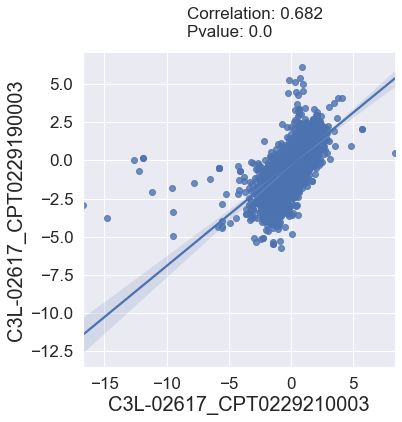

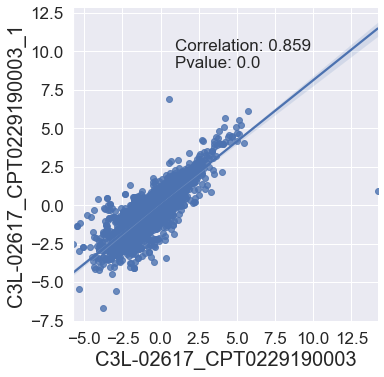

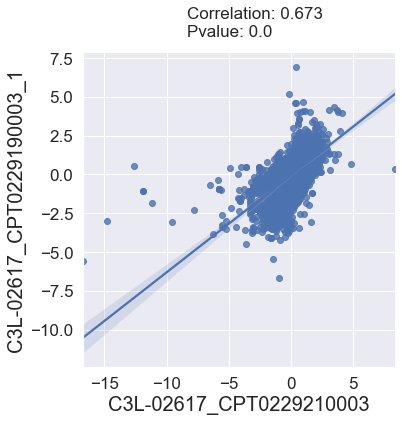

C3L-00994.N


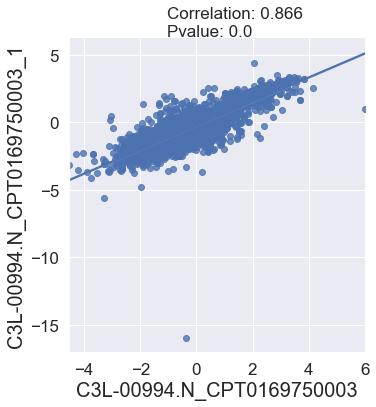

C3L-02617.N


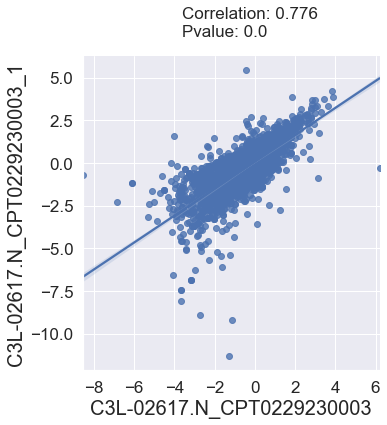

In [134]:
# compare correlations between pancan duplicates

df = pcdf
for col in df.columns:
    df[col] = pd.to_numeric(df[col])  

dup_list = ['C3L-02617', 'C3L-00994.N', 'C3L-02617.N'] 

for i in dup_list:
    if '.N' in i:
        dups = df.columns[df.columns.str.contains(i)].to_list()
    else:
        dups = df.columns[df.columns.str.contains(i) & ~ df.columns.str.contains('\.N')].to_list()
    
    print(i)
    first = dups[0]
    second = dups[1]
    
    plot_df = df[[first, second]].dropna(axis = 'index', how = 'any')
    xd = plot_df[first].min() + ((plot_df[first].max() - plot_df[first].min()) / 3) 
    yd = plot_df[second].max() + 2

    p.plot_pearson(plot_df, first, second, x_coor = xd, y_coor = yd, 
           hue = "none", title = "", ra_stats = True,
           show_plot = True)
        
    if len(dups) == 3:
        third = dups[2]
        plot_df2 = df[[second, third]].dropna(axis = 'index', how = 'any')
        xd = plot_df2[second].min() + ((plot_df2[second].max() - plot_df2[second].min()) / 3)
        yd = plot_df2[third].max() + 2                       
        p.plot_pearson(plot_df2, second, third, x_coor = xd, y_coor = yd,
               hue = "none", title = "", ra_stats = True,
               show_plot = True)
        
        plot_df3 = df[[first, third]].dropna(axis = 'index', how = 'any')
        xd = plot_df3[first].min() + ((plot_df3[first].max() - plot_df3[first].min()) / 3)
        yd = plot_df3[third].max() + 2
        p.plot_pearson(plot_df3, first, third, x_coor = xd, y_coor = yd,
               hue = "none", title = "", ra_stats = True,
               show_plot = True)

In [130]:
# Flagship
hnscc_dup = ['C3L-02617', 'C3L-00994.N', 'C3L-02617.N']
fdf = get_flag_df('phospho', hnscc, hnscc_dup)
fdf

cptac warning: Due to dropping the specified levels, dataframe now has 6904 duplicated column headers. (<ipython-input-26-b2b0f2ee8e36>, line 20)


Patient_ID,C3L-02617_flagship,C3L-00994.N_flagship,C3L-02617.N_flagship
Name,,,
A2M_S710,NaN,NaN,15.412727
A2M_S928,NaN,NaN,NaN
A2ML1_S658,NaN,NaN,NaN
A2ML1_S698,NaN,NaN,NaN
AAAS_S462,24.627331,23.12606,23.729201
...,...,...,...
ZZZ3_S381T388,NaN,NaN,NaN
ZZZ3_S391,22.452369,20.65330,20.989371
ZZZ3_S396,NaN,NaN,NaN


In [131]:
both = fdf.join(pcdf, how = 'inner')
both.head()
both

,C3L-02617_flagship,C3L-00994.N_flagship,C3L-02617.N_flagship,C3L-02617_CPT0229210003,C3L-02617_CPT0229190003,C3L-02617_CPT0229190003_1,C3L-00994.N_CPT0169750003,C3L-00994.N_CPT0169750003_1,C3L-02617.N_CPT0229230003,C3L-02617.N_CPT0229230003_1
Name,,,,,,,,,,
A2ML1_S658,NaN,NaN,NaN,NaN,-1.922906,-0.459314,2.401230,1.874197,-0.808742,NaN
AAAS_S462,24.627331,23.126060,23.729201,-0.004294,0.731831,0.869185,-1.475864,-0.896655,0.281972,0.121732
AAK1_S20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAK1_S21,21.263338,21.221686,21.079183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAK1_S624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
ZZEF1_S1537S1540,20.352143,NaN,NaN,NaN,0.103903,NaN,NaN,NaN,NaN,NaN
ZZEF1_S1540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZZEF1_S1801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

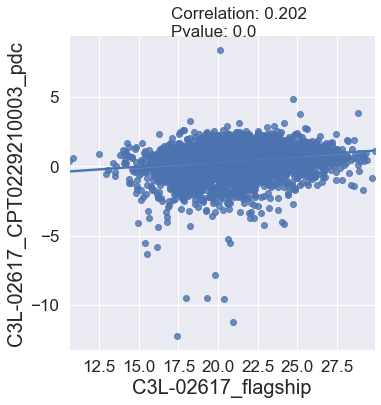

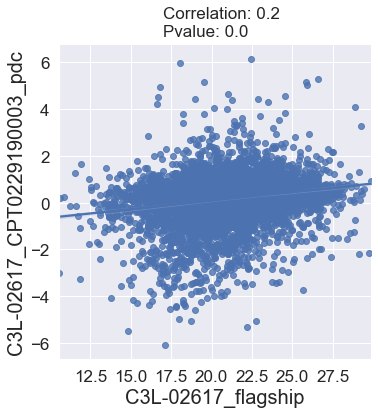

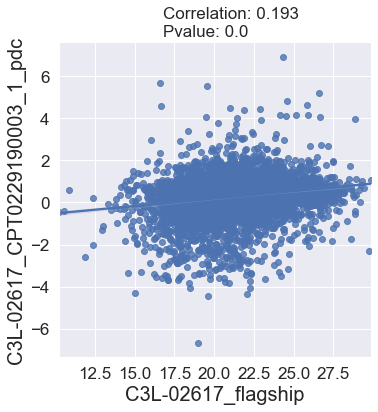

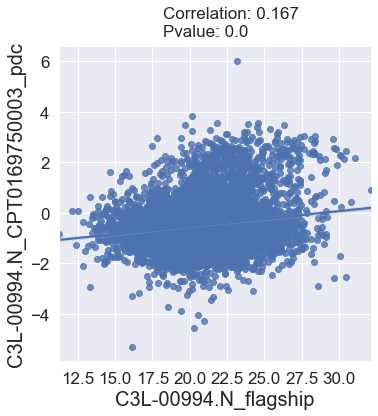

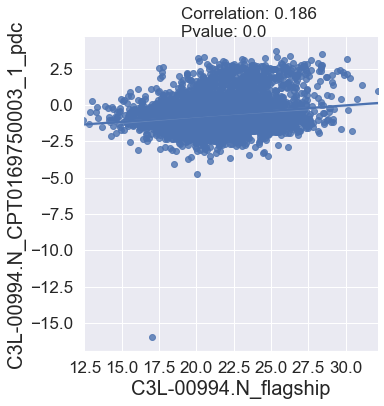

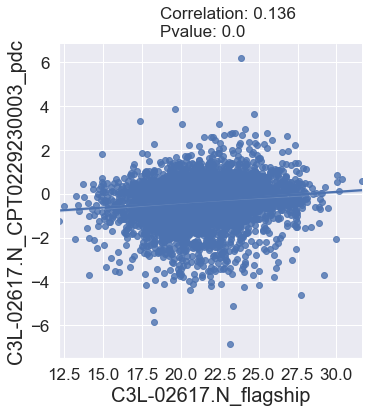

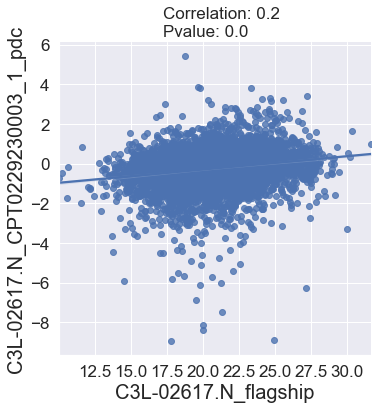

In [133]:
# compare to flagship - doesn't correlate well
wrap_lin_reg(both, hnscc_dup, y_lab = source_name)

# Luad

In [112]:
l = pc.PancanLuad()
luad = cptac.Luad()

In [113]:
# show which omics has duplicates
ca = l
source_name = 'pdc'
#source_name = 'umich'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
acetyl = ca.get_acetylproteomics(source_name)
print('prot:', set(prot.index.duplicated()), list(prot.index[prot.index.duplicated()]))
print('phospho:', set(phos.index.duplicated()), list(phos.index[phos.index.duplicated()]))
print('acetyl:', set(acetyl.index.duplicated()), list(acetyl.index[acetyl.index.duplicated()]))

prot: {False} []
phospho: {False, True} ['C3N-02379', 'C3N-02587']
acetyl: {False, True} ['C3N-02379', 'C3N-02587']


In [114]:
a=l.get_acetylproteomics('pdc')
a.isnull().values.any()

False

In [116]:
omics = 'phospho'
#omics = 'acetyl'
dup_list = ['C3N-02379', 'C3N-02587']
pcdf = get_pc_df(omics, l, 'pdc', dup_list)
pcdf

cptac warning: Due to dropping the specified levels, dataframe now has 1791 duplicated column headers. (<ipython-input-27-8e8438c23499>, line 23)


,C3N-02379_CPT0146580004,C3N-02379_CPT0146580004_1,C3N-02587_CPT0148080004,C3N-02587_CPT0148080004_1
Name,,,,
A2M_S710,0.3683,NaN,NaN,NaN
A2M_S923,NaN,NaN,NaN,NaN
AAAS_S462,0.7826,NaN,0.0526,0.191
AAAS_Y452,NaN,NaN,NaN,NaN
AAK1_S14,NaN,NaN,NaN,NaN
...,...,...,...,...
ZZZ3_S113,0.8639,1.0168,1.0241,0.6178
ZZZ3_S131,NaN,NaN,NaN,NaN
ZZZ3_S606,NaN,NaN,NaN,NaN


In [117]:
dup_list = ['C3N-02379', 'C3N-02587']
fdf = get_flag_df(omics, luad, dup_list)
fdf

cptac warning: Due to dropping the specified levels, dataframe now has 313 duplicated column headers. (<ipython-input-26-b2b0f2ee8e36>, line 20)


Patient_ID,C3N-02379_flagship,C3N-02587_flagship
Name,,
AAAS_S495,1.6253,-0.5442
AAAS_S541,0.1938,NaN
AAED1_S12,-0.1474,0.4084
AAGAB_S310S311,0.9514,0.1498
AAGAB_S311,0.3344,0.7129
...,...,...
ZZZ3_S113,1.1984,1.0357
ZZZ3_S391,-0.2666,-1.8126
ZZZ3_S397N429,NaN,-0.4941


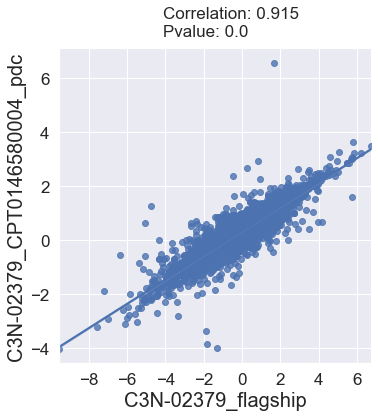

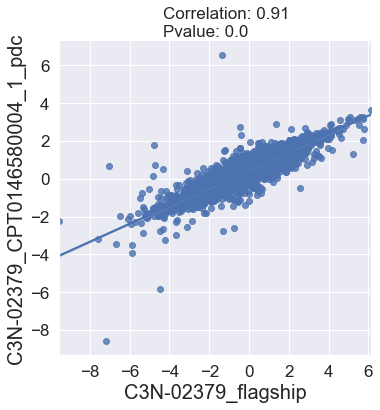

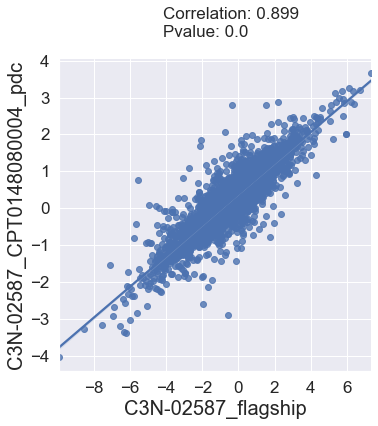

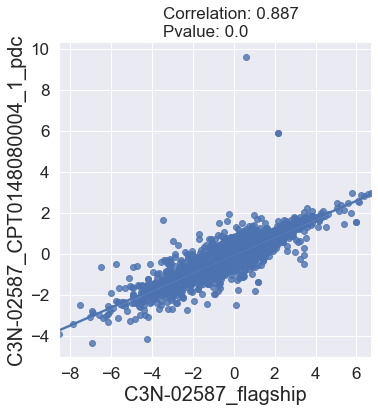

In [118]:
both = fdf.join(pcdf, how = 'inner')
both.head()
both

for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

wrap_lin_reg(both, dup_list, y_lab = source_name)

In [ ]:
print(omics)
get_corr(both, dup_list)